# Receding Horizon

This notebook is your playground to pull together techniques from the previous lessons! A solution here can be built from previous solutions (more or less) so we will offer no solution notebook this time.

Here's a suggested approach:

1. Load the colliders data
2. Discretize your search space into a grid or graph
3. Define a start and goal location
4. Find a coarse 2D plan from start to goal
5. Choose a location along that plan and discretize
   a local volume around that location (for example, you
   might try a 40x40 m area that is 10 m high discretized
   into 1m^3 voxels)
6. Define your goal in the local volume to a a node or voxel
   at the edge of the volume in the direction of the next
   waypoint in your coarse global plan.
7. Plan a path through your 3D grid or graph to that node
   or voxel at the edge of the local volume.  

We'll import some of the routines from previous exercises that you might find useful here.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Grid creation routine
from grid import create_grid, create_grid_and_edges
# Voxel map creation routine
from voxmap import create_voxmap, create_voxmap_in_area
# 2D A* planning routine (can you convert to 3D??)
from planning import a_star, a_star_2d_graph
# Random sampling routine
from sampling import Sampler

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = 14, 14

## Load Data

In [3]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [4]:
flight_altitude = 1
safety_distance = 5
grid = create_grid(data, flight_altitude, safety_distance)

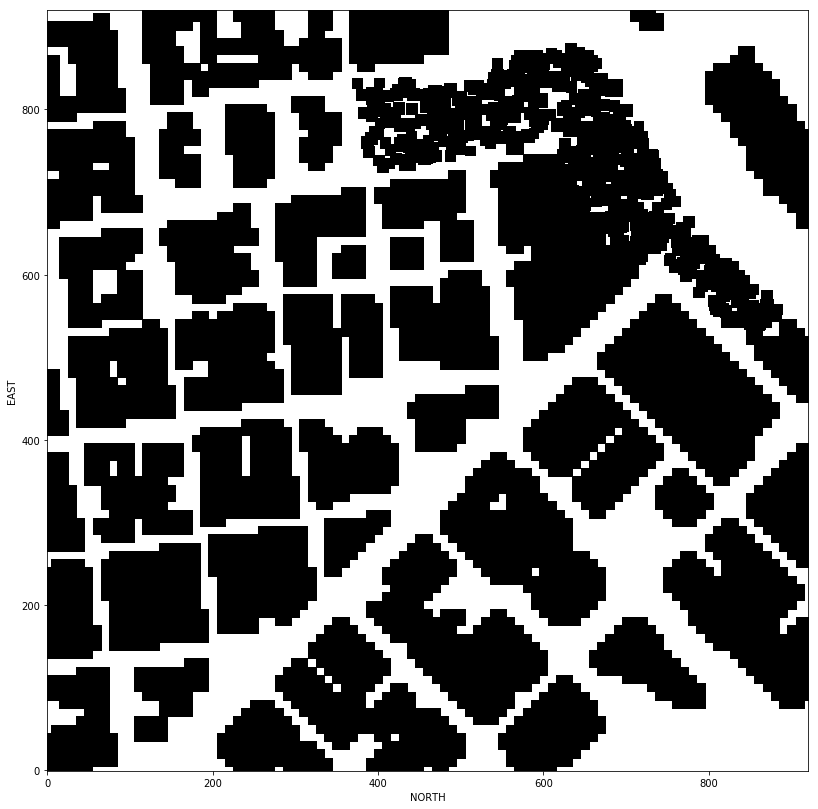

In [5]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

In [6]:
grid, edges = create_grid_and_edges(data, flight_altitude, safety_distance)

In [7]:
start_ne = (25,  100)
goal_ne = (750, 120)

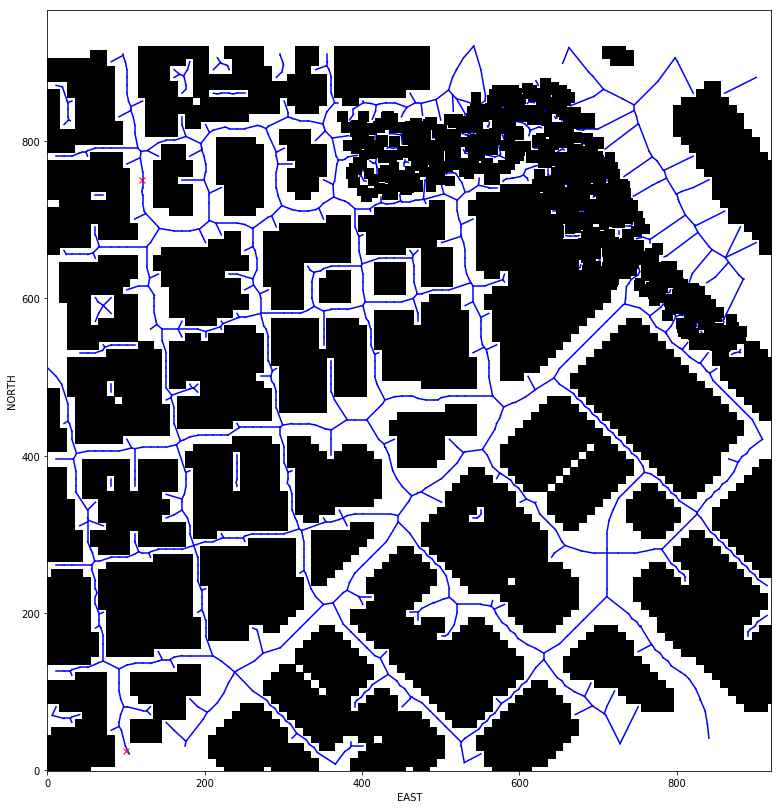

In [8]:
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [9]:
def heuristic_2d(n1, n2):
    return ((n1[0]-n2[0])**2+(n1[1]-n2[1])**2)**0.5

In [10]:
import networkx as nx

G = nx.Graph()

for e in edges:
    p1 = e[0]
    p2 = e[1]
    dist = np.linalg.norm(np.array(p2) - np.array(p1))
    G.add_edge(p1, p2, weight=dist)


In [11]:
def find_start_goal_2d(edges, start, goal):
    # TODO: find start and goal on skeleton
    # Some useful functions might be:
        # np.nonzero()
        # np.transpose()
        # np.linalg.norm()
        # np.argmin()
    skel_points = []
    for ep in edges:
        skel_points.append(ep[0])
        skel_points.append(ep[1])
    near_start = skel_points[np.argmin([np.linalg.norm(np.array(start)-np.array(point)) for point in skel_points])]
    near_goal = skel_points[np.argmin([np.linalg.norm(np.array(goal)-np.array(point)) for point in skel_points])]
    return (near_start[0], near_start[1]), (near_goal[0], near_goal[1])

In [12]:
start_2d, end_2d = find_start_goal_2d(edges, start_ne, goal_ne)

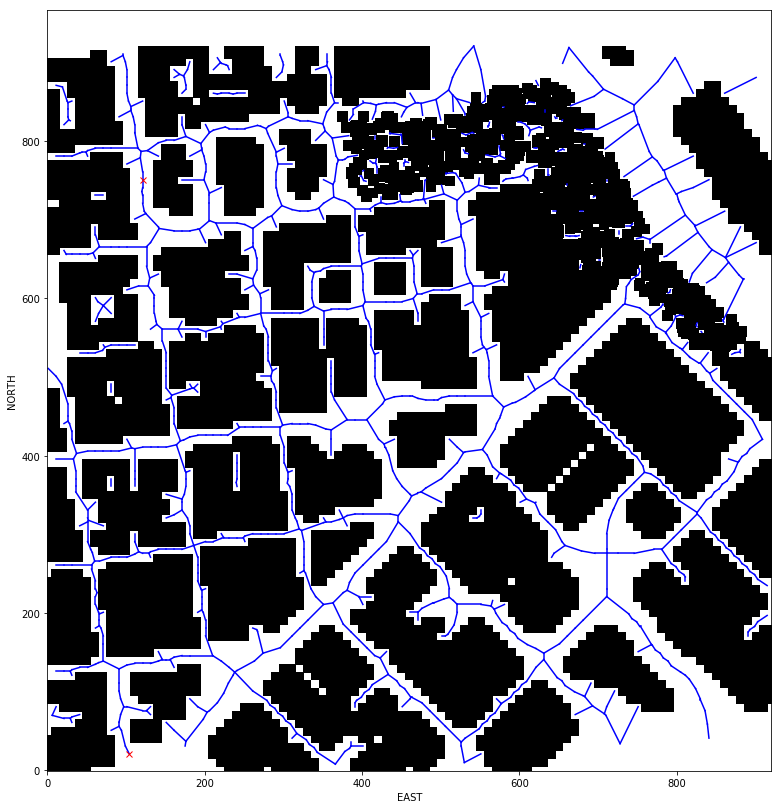

In [13]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
plt.plot(start_2d[1], start_2d[0], 'rx')
plt.plot(end_2d[1], end_2d[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [14]:
path_2d, cost_2d = a_star_2d_graph(G, heuristic_2d, start_2d, end_2d)

Found a path.


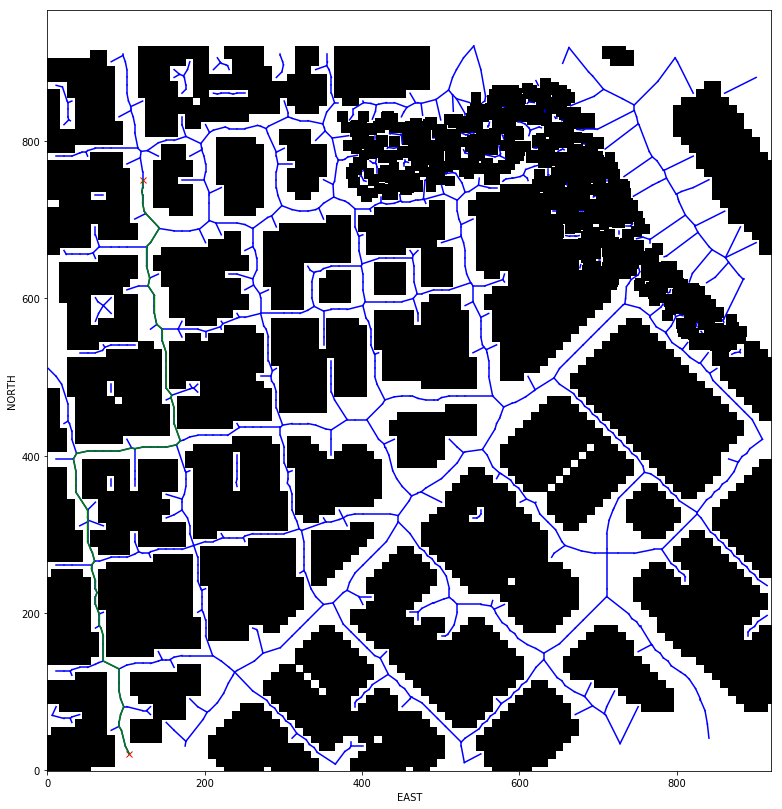

In [15]:
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
plt.plot(start_2d[1], start_2d[0], 'rx')
plt.plot(end_2d[1], end_2d[0], 'rx')

pp = np.array(path_2d)
plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [16]:
def select_random_point_in_2d_path(path):
    num_points = len(path)
    index = np.random.randint(1, num_points-1)
    direction = np.random.choice([-1, 1])
    [f, t] = np.sort([index - direction, index])
    p1 = path[f]
    p2 = path[t]
    
    return (
        np.random.uniform(p1[0], p2[0], 1)[0],
        np.random.uniform(p1[1], p2[1], 1)[0],
    )
    

In [17]:
random_point = select_random_point_in_2d_path(path_2d)
print(random_point)

(406.0, 62.476931125525766)


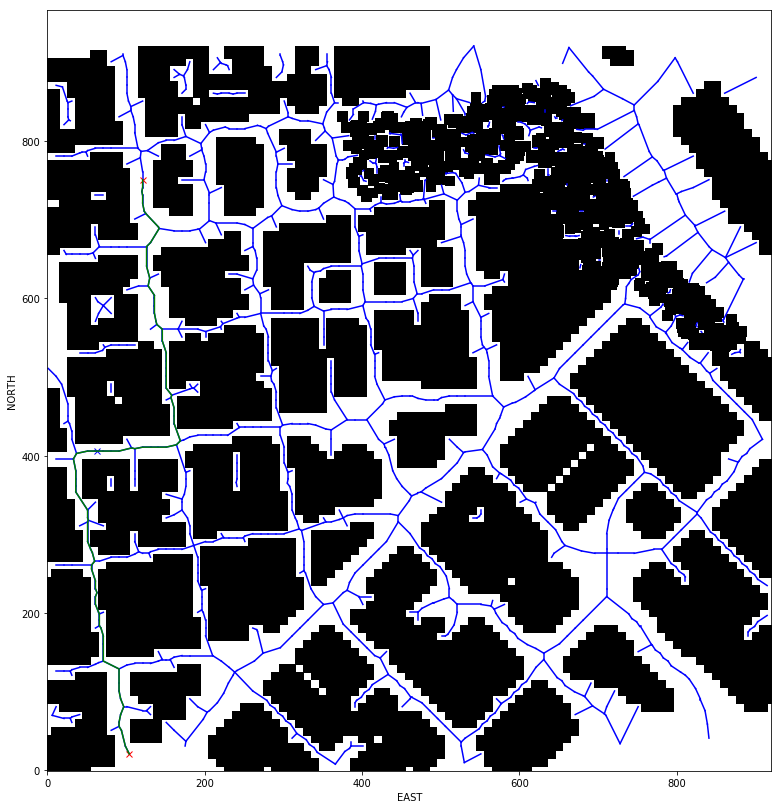

In [18]:
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
plt.plot(start_2d[1], start_2d[0], 'rx')
plt.plot(end_2d[1], end_2d[0], 'rx')

plt.plot(random_point[1], random_point[0], 'bx')

pp = np.array(path_2d)
plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [19]:
from shapely.geometry.polygon import Polygon


def limit_value_int(value, vmin, vmax):
    maxvalue = np.max([value, vmin])
    minvalue = np.min([maxvalue, maxvalue])
    
    return int(minvalue)

def create_voxmap_in_area(data, area_center, horizontal_delta, vertical_delta, voxel_size=5):
    """
    Returns a grid representation of a 3D configuration space
    based on given obstacle data.
    
    The `voxel_size` argument sets the resolution of the voxel map. 
    """
    # minimum and maximum north coordinates
    north_min = np.floor(np.amin(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.amax(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.amin(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.amax(data[:, 1] + data[:, 4]))

    # maximum altitude
    alt_max = np.ceil(np.amax(data[:, 2] + data[:, 5]))
    
    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(2*horizontal_delta) // voxel_size
    east_size = int(2*horizontal_delta) // voxel_size
    alt_size = int(2*vertical_delta) // voxel_size
    
    area_coordinates = [
        (area_center[0]-horizontal_delta, area_center[1]-horizontal_delta),
        (area_center[0]-horizontal_delta, area_center[1]+horizontal_delta),
        (area_center[0]+horizontal_delta, area_center[1]+horizontal_delta),
        (area_center[0]+horizontal_delta, area_center[1]-horizontal_delta),
    ]
    
    area_polygon = Polygon(area_coordinates)
    
    # Create an empty grid
    voxmap = np.zeros((north_size, east_size, alt_size), dtype=np.bool)

    for i in range(data.shape[0]):
        # TODO: fill in the voxels that are part of an obstacle with `True`
        #
        # i.e. grid[0:5, 20:26, 2:7] = True
        
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        obstacle = [
            int(north - d_north - north_min),
            int(north + d_north - north_min),
            int(east - d_east - east_min),
            int(east + d_east - east_min),
        ]
        
        obstacle_polygon = Polygon([
            (obstacle[0], obstacle[2]),
            (obstacle[0], obstacle[3]),
            (obstacle[1], obstacle[3]),
            (obstacle[1], obstacle[2]),
        ])
        
        # check if obstacle in area of interest
        if not area_polygon.contains(obstacle_polygon) and not obstacle_polygon.crosses(area_polygon):
            continue

        obstacle_coordinates = [
            limit_value_int(
                north - d_north - north_min - area_center[0] + horizontal_delta,
                0, 
                2 * horizontal_delta
            ) // voxel_size,
            limit_value_int(
                north + d_north - north_min - area_center[0] + horizontal_delta,
                0, 
                2 * horizontal_delta
            ) // voxel_size,
            limit_value_int(
                east - d_east - east_min - area_center[1] + horizontal_delta,
                0, 
                2 * horizontal_delta
            ) // voxel_size,
            limit_value_int(
                east + d_east - east_min - area_center[1] + horizontal_delta,
                0, 
                2 * horizontal_delta
            ) // voxel_size,
        ]

        height = limit_value_int(
            alt + d_alt - area_center[2] + vertical_delta, 
            0, 
            2*vertical_delta
        ) // voxel_size
                
        voxmap[
            obstacle_coordinates[0]:obstacle_coordinates[1], 
            obstacle_coordinates[2]:obstacle_coordinates[3], 
            0:height
        ] = True

    return voxmap

In [20]:
local_voxmap = create_voxmap_in_area(data, (random_point[0], random_point[1], flight_altitude), 40, 40, 1)

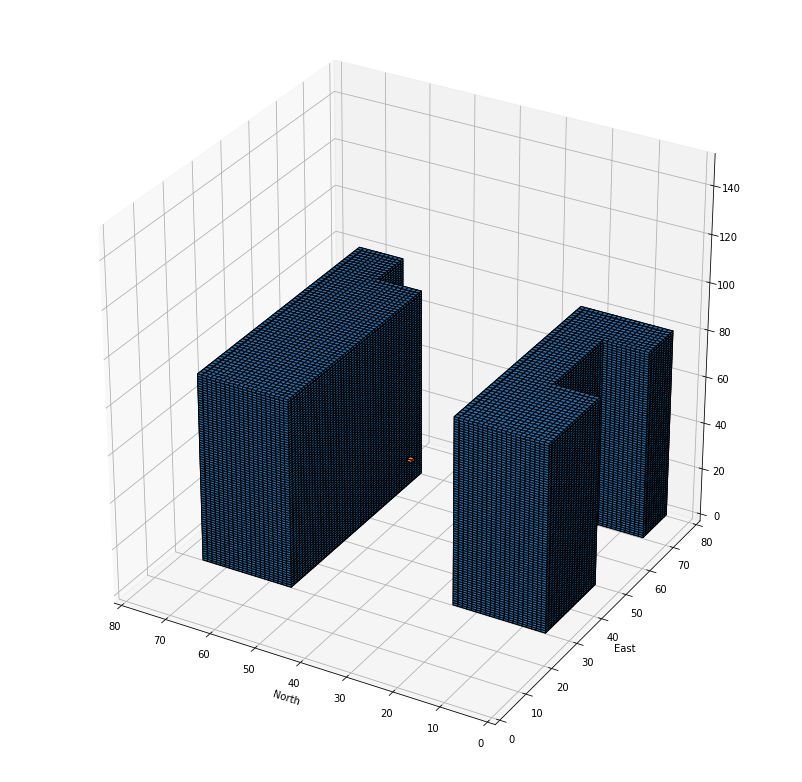

In [21]:
from mpl_toolkits.mplot3d import Axes3D

start_voxel = np.zeros((80, 80, 80), dtype=np.bool)
start_voxel[40, 40, 40] = True

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(local_voxmap, edgecolor='k')
ax.voxels(start_voxel, edgecolor='k')
ax.set_xlim(local_voxmap.shape[0], 0)
ax.set_ylim(0, local_voxmap.shape[1])
# add 100 to the height so the buildings aren't so tall
ax.set_zlim(0, local_voxmap.shape[2]+70)

plt.xlabel('North')
plt.ylabel('East')

plt.show()

In [22]:
from shapely.geometry import LineString, Point

def find_voxel_destination_point(local_voxel_map, horizontal_delta, center_point, path):
    area_polygon = Polygon([
        (center_point[0]-horizontal_delta, center_point[1]-horizontal_delta),
        (center_point[0]-horizontal_delta, center_point[1]+horizontal_delta),
        (center_point[0]+horizontal_delta, center_point[1]+horizontal_delta),
        (center_point[0]+horizontal_delta, center_point[1]-horizontal_delta),
    ])
    intersections = []
    for i in range(0, len(path)-1):
        p1 = path[i]
        p2 = path[i+1]
        line = LineString([p1, p2])
        if not area_polygon.crosses(line):
            continue
        else:
            line = LineString([p1, p2])
            intersection = area_polygon.intersection(line).coords[0]
            intersections.append((
                limit_value_int(intersection[0] - center_point[0] + horizontal_delta, 0, 2*horizontal_delta),
                limit_value_int(intersection[1] - center_point[1] + horizontal_delta, 0, 2*horizontal_delta)
            ))
    return intersections[len(intersections)-1]

In [23]:
intersection = find_voxel_destination_point(local_voxmap, 40, random_point, path_2d)
print(intersection)

(40, 68)


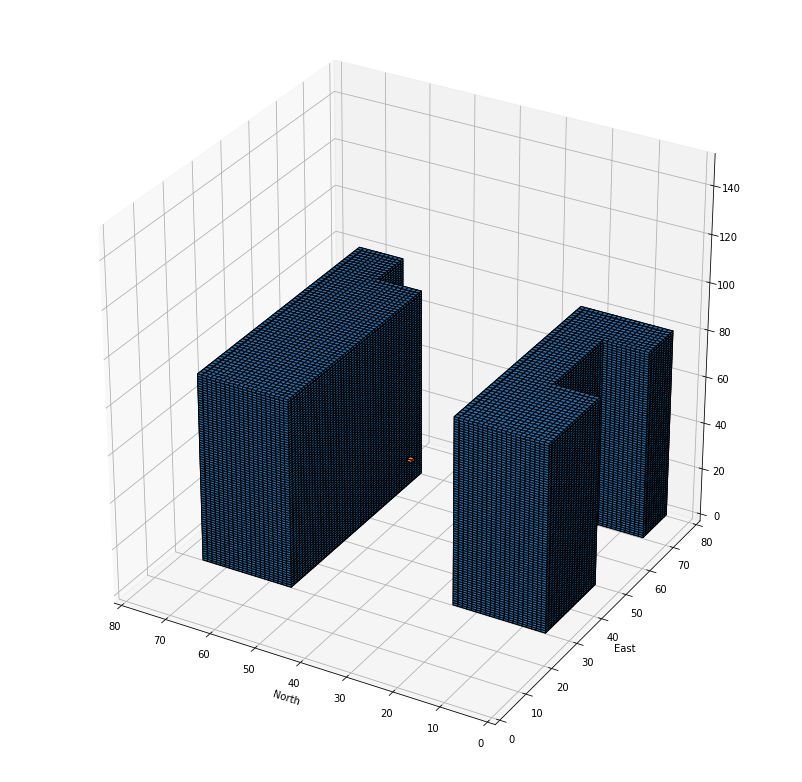

In [24]:
from mpl_toolkits.mplot3d import Axes3D

start_voxel = np.zeros((80, 80, 80), dtype=np.bool)
start_voxel[40, 40, 40] = True

end_voxel = np.zeros((80, 80, 80), dtype=np.bool)
end_voxel[intersection[0], intersection[1], 40] = True

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(local_voxmap, edgecolor='k')
ax.voxels(start_voxel, edgecolor='k')
ax.voxels(end_voxel, edgecolor='k')
ax.set_xlim(local_voxmap.shape[0], 0)
ax.set_ylim(0, local_voxmap.shape[1])
# add 100 to the height so the buildings aren't so tall
ax.set_zlim(0, local_voxmap.shape[2]+70)

plt.xlabel('North')
plt.ylabel('East')

plt.show()

In [25]:
def convert_3d_to_2d(grid, altitude):
    """
    Returns a grid representation of a 2D configuration space
    based on given obstacle data, drone altitude and safety distance
    arguments.
    """
    
    grid_2d = np.zeros((grid.shape[0], grid.shape[1]))
    
    for i in range(0, grid.shape[0]):
        for j in range(0, grid.shape[1]):
            grid_2d[i, j] = grid[i, j, altitude]

    return grid_2d


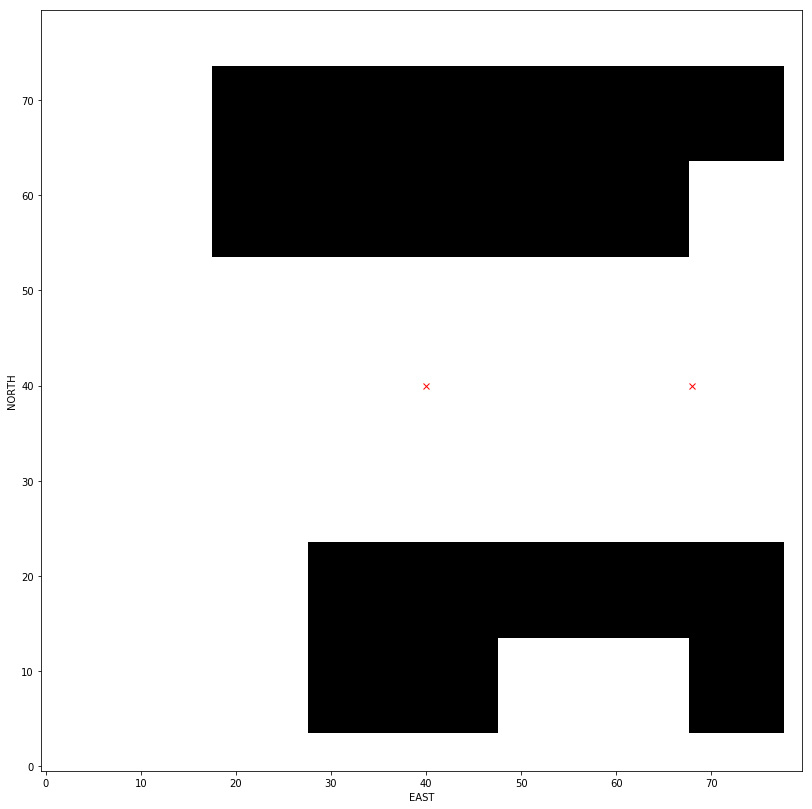

In [26]:
grid_2d = convert_3d_to_2d(local_voxmap, 40)

plt.plot(40, 40, 'rx')
plt.plot(intersection[1], intersection[0], 'rx')

plt.imshow(grid_2d, origin='lower', cmap='Greys') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [27]:
def collides(voxmap, point):
    return voxmap[int(point[0]), int(point[1]), int(point[2])] == True

In [28]:
from sklearn.neighbors import KDTree
import numpy as np

In [29]:
num_samples = 50

xvals = np.append(np.random.uniform(0, 79, num_samples), 40)
yvals = np.append(np.random.uniform(0, 79, num_samples), 40)
zvals = np.append(np.random.uniform(0, 79, num_samples), 40)

samples = list(zip(xvals, yvals, zvals))

points = []
for point in samples:
    if not collides(local_voxmap, point):
        points.append(point)

In [30]:
"""
N-D Bresenham line algo
"""
import numpy as np
def _bresenhamline_nslope(slope):
    """
    Normalize slope for Bresenham's line algorithm.

    >>> s = np.array([[-2, -2, -2, 0]])
    >>> _bresenhamline_nslope(s)
    array([[-1., -1., -1.,  0.]])

    >>> s = np.array([[0, 0, 0, 0]])
    >>> _bresenhamline_nslope(s)
    array([[ 0.,  0.,  0.,  0.]])

    >>> s = np.array([[0, 0, 9, 0]])
    >>> _bresenhamline_nslope(s)
    array([[ 0.,  0.,  1.,  0.]])
    """
    scale = np.amax(np.abs(slope), axis=1).reshape(-1, 1)
    zeroslope = (scale == 0).all(1)
    scale[zeroslope] = np.ones(1)
    normalizedslope = np.array(slope, dtype=np.double) / scale
    normalizedslope[zeroslope] = np.zeros(slope[0].shape)
    return normalizedslope

def _bresenhamlines(start, end, max_iter):
    """
    Returns npts lines of length max_iter each. (npts x max_iter x dimension) 

    >>> s = np.array([[3, 1, 9, 0],[0, 0, 3, 0]])
    >>> _bresenhamlines(s, np.zeros(s.shape[1]), max_iter=-1)
    array([[[ 3,  1,  8,  0],
            [ 2,  1,  7,  0],
            [ 2,  1,  6,  0],
            [ 2,  1,  5,  0],
            [ 1,  0,  4,  0],
            [ 1,  0,  3,  0],
            [ 1,  0,  2,  0],
            [ 0,  0,  1,  0],
            [ 0,  0,  0,  0]],
    <BLANKLINE>
           [[ 0,  0,  2,  0],
            [ 0,  0,  1,  0],
            [ 0,  0,  0,  0],
            [ 0,  0, -1,  0],
            [ 0,  0, -2,  0],
            [ 0,  0, -3,  0],
            [ 0,  0, -4,  0],
            [ 0,  0, -5,  0],
            [ 0,  0, -6,  0]]])
    """
    if max_iter == -1:
        max_iter = np.amax(np.amax(np.abs(end - start), axis=1))
    npts, dim = start.shape
    nslope = _bresenhamline_nslope(end - start)

    # steps to iterate on
    stepseq = np.arange(1, max_iter + 1)
    stepmat = np.tile(stepseq, (dim, 1)).T

    # some hacks for broadcasting properly
    bline = start[:, np.newaxis, :] + nslope[:, np.newaxis, :] * stepmat

    # Approximate to nearest int
    return np.array(np.rint(bline), dtype=start.dtype)

def bresenhamline(start, end, max_iter=5):
    """
    Returns a list of points from (start, end] by ray tracing a line b/w the
    points.
    Parameters:
        start: An array of start points (number of points x dimension)
        end:   An end points (1 x dimension)
            or An array of end point corresponding to each start point
                (number of points x dimension)
        max_iter: Max points to traverse. if -1, maximum number of required
                  points are traversed

    Returns:
        linevox (n x dimension) A cumulative array of all points traversed by
        all the lines so far.

    >>> s = np.array([[3, 1, 9, 0],[0, 0, 3, 0]])
    >>> bresenhamline(s, np.zeros(s.shape[1]), max_iter=-1)
    array([[ 3,  1,  8,  0],
           [ 2,  1,  7,  0],
           [ 2,  1,  6,  0],
           [ 2,  1,  5,  0],
           [ 1,  0,  4,  0],
           [ 1,  0,  3,  0],
           [ 1,  0,  2,  0],
           [ 0,  0,  1,  0],
           [ 0,  0,  0,  0],
           [ 0,  0,  2,  0],
           [ 0,  0,  1,  0],
           [ 0,  0,  0,  0],
           [ 0,  0, -1,  0],
           [ 0,  0, -2,  0],
           [ 0,  0, -3,  0],
           [ 0,  0, -4,  0],
           [ 0,  0, -5,  0],
           [ 0,  0, -6,  0]])
    """
    return _bresenhamlines(start, end, max_iter).reshape(-1, start.shape[-1])


In [31]:
def can_connect(p1, p2):
    if p1 is p2:
        return False
    
    points = bresenhamline(np.array([p1]), np.array([p2]))
    for p in points:
        if local_voxmap[int(p[0]), int(p[1]), int(p[2])] == True:
            return False
    return True

def create_graph():
    g = nx.Graph()
    tree = KDTree(points)
    for point in points:
        (distances, indices) = tree.query([point], k=10, return_distance=True)
        for (d, i) in zip(distances[0], indices[0]):
            if can_connect(point, points[i]):
                g.add_edge(point, points[i], distance=d)
    return g

g = create_graph()

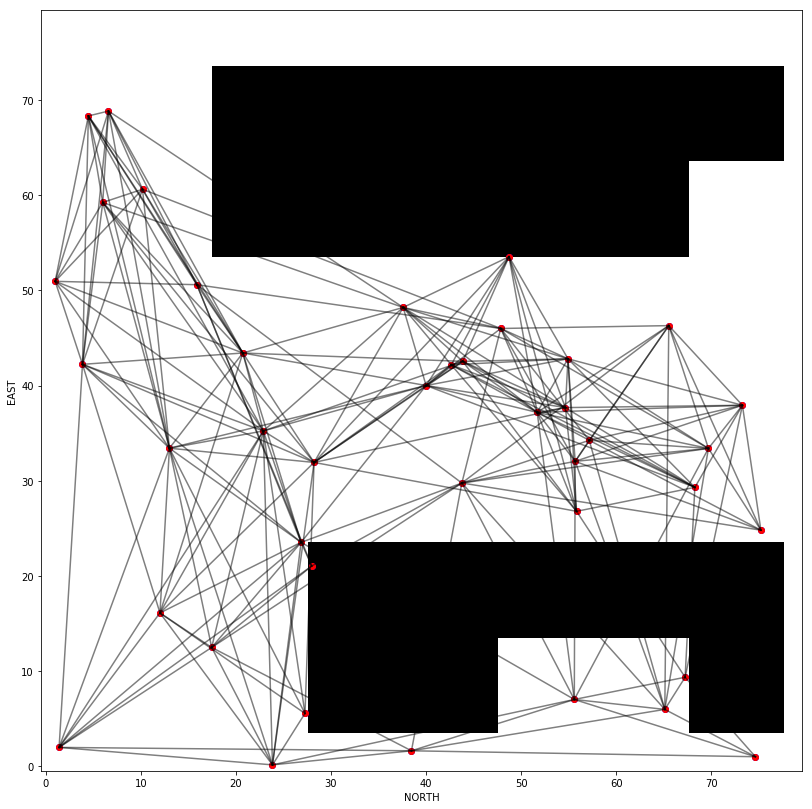

In [32]:
fig = plt.figure()

plt.imshow(grid_2d, cmap='Greys', origin='lower')

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
   plt.plot([n1[1], n2[1]], [n1[0], n2[0] ], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in points:
   plt.scatter(n1[1], n1[0], c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1], n1[0], c='red')
    

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

In [33]:
def heuristic_3d(n1, n2):
    # TODO:
    return ((n1[0]-n2[0])**2 + (n1[1]-n2[1])**2 + (n1[2]-n2[2])**2)**0.5

In [34]:
from queue import PriorityQueue
def a_star_3d(grid, h, start, goal):

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for (next_node, data) in grid[current_node].items():
                branch_cost = data['distance']
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node)
                    queue.put((queue_cost, next_node))
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost


In [35]:
def find_start_goal_3d(edges, start, goal):
    # TODO: find start and goal on skeleton
    # Some useful functions might be:
        # np.nonzero()
        # np.transpose()
        # np.linalg.norm()
        # np.argmin()
    skel_points = []
    for ep in edges:
        skel_points.append(ep[0])
        skel_points.append(ep[1])
    near_start = skel_points[np.argmin([np.linalg.norm(np.array(start)-np.array(point)) for point in skel_points])]
    near_goal = skel_points[np.argmin([np.linalg.norm(np.array(goal)-np.array(point)) for point in skel_points])]
    return near_start, near_goal

start_ne = (40,  40, 40)
goal_ne = (intersection[0], intersection[1], 40)

start, end = find_start_goal_3d(g.edges, start_ne, goal_ne)
print(start, end)



(40.0, 40.0, 40.0) (37.92544538874585, 73.24896731280182, 48.085901560843205)


In [36]:
path, cost = a_star_3d(g, heuristic_3d, start, end)

Found a path.


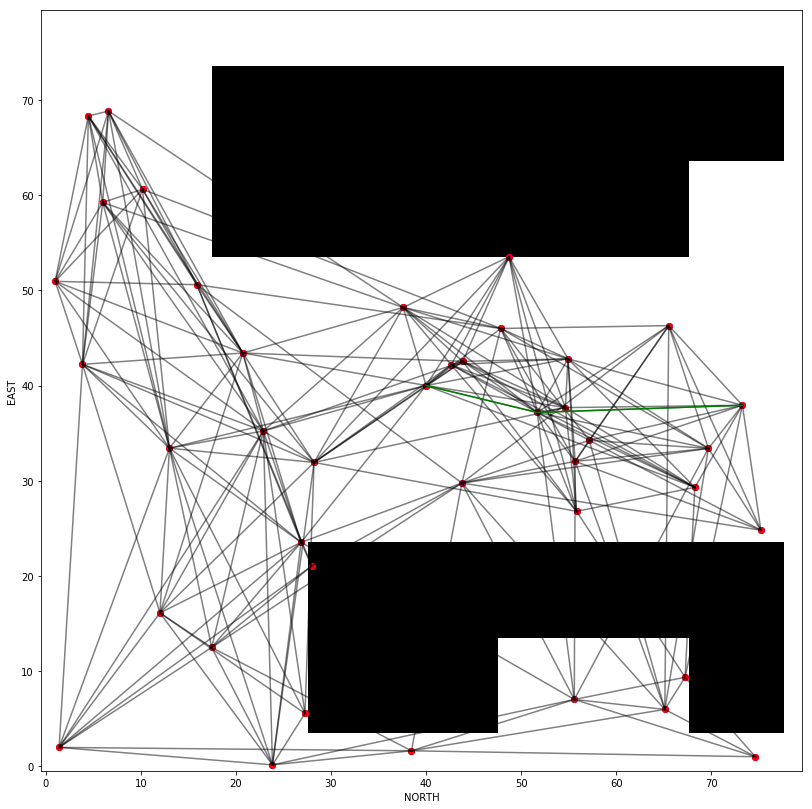

In [37]:
fig = plt.figure()

plt.imshow(grid_2d, cmap='Greys', origin='lower')

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
   plt.plot([n1[1], n2[1]], [n1[0], n2[0] ], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in points:
   plt.scatter(n1[1], n1[0], c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1], n1[0], c='red')
    
pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')     
    
plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()